## Text Classification Using Scikit-Learn

### Content

* Objective
* Dataset
* Data Preparation Using R
* Data Exploration Using Python



### Objective
#### To reduce the processing time of manual coding

Open-end responses in a survey is always a great way to retrieve valuable information/ feedback from respondents. It allows respondents to express their thoughts and opinions through their own words. 

Manual coding is the most often way performed on the open-end responses so that the responses can be quantified and analysed in the same way as multiple response questions. 

However, manual coding is a very tedious and time consuming process as it requires coders to read and categorize each of the responses one by one.   

### Dataset

<img src="https://pinnacledealersolutions.net/wp-content/uploads/2017/05/blog-img-dealer-man-handships.jpg", width=400>


Customer Experience is key to success in automotive industry. 
The dataset that I'm using is the actual feedback/ comment from the customers about their dealership experience. 

Each feedback/comment will have a few classified categories (up to 8 categories) that were manually done by coder previously. So, I'm going to build a model to train on the labeled dataset with the pre-defined categories and feed the model with unseen data so that the model is able to classify them into categories.

### Data Preparation Using R

#### Library
    ibrary(plyr)

#### Set Working Directory
    setwd("C:\\Users\\SiowHui.Chong\\Desktop\\EDS4\\Enterprise_Data_Science4_EDS4\\Project\\Data")

#### Load Data from CSV
    raw <- read.csv("DealershipExperience_1.csv", header = TRUE, sep = ",")
<div class="alert alert-success">
Due to the encoding issue, i got special character (i..id) appended to the first variable in my first column, so I will rename my first column from "i...id" to "id".
</div>
    
    names(raw)[1]<-"id"

#### Data Preparation

* Remove the double quote " in string variable (feedback/comment) 
    
    `raw <- as.data.frame(lapply(raw, function(x) gsub('"', "", x)))`


* Select all the categorical variables

    `initialdf <- subset(raw, select = c(1,6:13))`
    

* Transform all the categories to individual columns 

<img src="./Data/DataViewfromR.JPG", width=1000>

<div class="alert alert-success">
Create another list without the first column. Using apply loop to get the sequence of maximum value in all the rows and convert it to integer 
</div>  

    seqlist <- apply(initialdf[-1], 1, function(x) as.integer(seq_len(max(x, na.rm = TRUE)) %in% x))
<div class="alert alert-success">
Append NAs at the end of each row to make the lengths same in the list and combine back with the first column 
</div> 

    replacelist <- cbind(initialdf[1], do.call(rbind, lapply(seqlist, `length<-`, max(lengths(seqlist)))))

<div class="alert alert-success">
Replace NAs with 0 
</div> 

    replacelist[is.na(replacelist)] <- 0

<div class="alert alert-success">
Rename the newly created columns to v1 (for category=1), v2 (for category=2), v55 (for category=55) etc.
</div> 

    colnames(replacelist)[-1] <- paste0('v', 1:99)

<div class="alert alert-success">
Remove columns without any categories
</div> 
    
    removedf <- replacelist[, colSums(replacelist != 0) > 0]
    
#### Merge transform data to original dataset Data to CSV
    merged <- join(raw, removedf, by="id")

#### Export Data to CSV

    write.table(merged, "final.csv", sep="," ,row.names = FALSE, quote = TRUE)

### Data Exploration Using Python 

#### Library

In [1]:
import pandas as pd
import re
import numpy as np
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

 #### Load Data from CSV

In [3]:
data = pd.read_csv('./Data/final.csv',sep=',')

#### Data Exploratory

In [4]:
#to view first 10 rows of data
data.head(10)
#We can see that all the categories (v1 to v97) are binary variables (with class=0 or =1)

,id,QUARTER,VisitedDealer,OtherDealerSatisfaction,Verbatim,C1,C2,C3,C4,C5,...,v64,v65,v70,v71,v72,v73,v80,v81,v90,v97
0,4,1,33,7,dodgy sales guy,60,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,5,1,23,9,Good experience with them but they do not offe...,63,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,7,1,60,9,The sales person wasn`t very helpful in meetin...,48,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,10,1,46,8,"Friendly and knowledgeable staff, just ended u...",1,4.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,11,1,23,8,Helpful,2,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
5,13,1,22,10,All staff and service were excellent,32,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
6,14,1,46,10,"Salesperson was friendly, went above & beyond ...",1,5.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
7,16,1,23,1,Not happy,81,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
8,17,1,33,10,"Very well appointed showroom, very friendly t...",26,1.0,16.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
9,19,1,40,6,They were ok,32,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [5]:
#to list down all the information about dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45403 entries, 0 to 45402
Data columns (total 62 columns):
id                         45403 non-null int64
QUARTER                    45403 non-null int64
VisitedDealer              45403 non-null int64
OtherDealerSatisfaction    45403 non-null int64
Verbatim                   45403 non-null object
C1                         45403 non-null int64
C2                         16688 non-null float64
C3                         4482 non-null float64
C4                         882 non-null float64
C5                         177 non-null float64
C6                         29 non-null float64
C7                         6 non-null float64
C8                         2 non-null float64
v1                         45403 non-null int64
v2                         45403 non-null int64
v3                         45403 non-null int64
v4                         45403 non-null int64
v5                         45403 non-null int64
v6                         4

In [6]:
#to  create another new text variable for verbatim and change the type to string
data['text'] = data['Verbatim'].astype(str)

### How to "pre-process" texts / words?

* Remove all the numeric values from the texts
* Convert all the texts to lowercase
* Normalise the word to base form
    
    `PorterStemmer() WordNetLemmatizer()`
<div class="alert alert-success">  
Lemmatization and stemming are special cases of normalization. 
The goal of both stemming and lemmatization is to identify a canonical representative for a set of related word forms to a common base form. 
</div> 
<div class="alert alert-success">  
Stemmer operates on a single word without knowledge of the context , and therefore cannot discriminate between words which have different meanings depending on part of speech.
Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words.
<br>
E.g. <br>
The word "better" has "good" as its lemma. This link is missed by stemming, as it requires a dictionary look-up.
<br>
The word "walk" is the base form for word "walking/waits/waited", and hence this is matched in both stemming and lemmatisation.
</div> 


* Count the occurrence of each word 

    `CountVectorizer=() TfidfVectorizer()`
<div class="alert alert-success">
Texts / Comments are a series of words. In order to run machine learning algorithms,  we need to convert all the texts into into numerical feature vectors. We will have to segment each word respectively (splitting by space) and then count number of times each word occurs, and finally assign each word to an unique integer id. Each unique word will correspond to a feature.  (descriptive feature).
</div> 
<div class="alert alert-success">
Using CountVectorizer from Scikit-learn will help to convert all words to matrix and count the count number of times each word occurs. TfidfVectorizer will assign different weights to every single word (most frequent word will have lower weight while less frequent word will have higher weight due to the relevancy / importance)
</div>  


* To filter out useless data 

    `stopwords.words()`
<div class="alert alert-success">  
A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that will be filtered from the text to process accordingly.
We do not want these words to take up the processing time and memory when running a model. 

In [7]:
#Remove all the numeric values from the texts
#Convert all the texts to lowercase
data['cleaned0'] = data['text'].apply(lambda x: " ".join([i for i in re.sub("[^a-zA-Z]"," ",x).split()]).lower())
#Normalise the word to base form
porter = PorterStemmer()
wnl = WordNetLemmatizer()
data['cleaned'] = data['cleaned0'].apply(lambda i: wnl.lemmatize(i) if wnl.lemmatize(i).endswith('e') else porter.stem(i))

In [8]:
data.tail(10)

,id,QUARTER,VisitedDealer,OtherDealerSatisfaction,Verbatim,C1,C2,C3,C4,C5,...,v71,v72,v73,v80,v81,v90,v97,text,cleaned0,cleaned
45393,93087,4,40,10,They were helpful and friendly.,2,1.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,They were helpful and friendly.,they were helpful and friendly,they were helpful and friendli
45394,93089,4,23,8,It was not easy to take a test drive.,61,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,It was not easy to take a test drive.,it was not easy to take a test drive,it was not easy to take a test drive
45395,93090,4,37,9,Sales man very keen to sell me the car and exp...,5,3.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,Sales man very keen to sell me the car and exp...,sales man very keen to sell me the car and exp...,sales man very keen to sell me the car and exp...
45396,93091,4,28,10,i own one already,31,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,i own one already,i own one already,i own one alreadi
45397,93092,4,26,6,I wasn`t happy with dealer.,60,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,I wasn`t happy with dealer.,i wasn t happy with dealer,i wasn t happy with deal
45398,93094,4,23,4,The salesperson was very pushy and said he was...,51,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,The salesperson was very pushy and said he was...,the salesperson was very pushy and said he was...,the salesperson was very pushy and said he was...
45399,93095,4,40,8,Not as knowledgeable about the vehicle.,43,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,Not as knowledgeable about the vehicle.,not as knowledgeable about the vehicle,not as knowledgeable about the vehicle
45400,93097,4,46,10,did not try to oversell or be pushey and gave ...,7,16.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,did not try to oversell or be pushey and gave ...,did not try to oversell or be pushey and gave ...,did not try to oversell or be pushey and gave ...
45401,93108,4,5,7,It took a while to be acknowledged,45,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,It took a while to be acknowledged,it took a while to be acknowledged,it took a while to be acknowledg
45402,93111,4,42,5,"While the dealer was polite and knowledgeable,...",52,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,"While the dealer was polite and knowledgeable,...",while the dealer was polite and knowledgeable ...,while the dealer was polite and knowledgeable ...


Due to lack of time, from the 49 categories, I'm going to select 2 categories (v1,v2) with positive comments and another 2 (v45,v46) with negative comments to build 4 separate models.

In [9]:
#To get the summary for each category
data[['v1','v2','v45', 'v46']].apply(pd.Series.value_counts)

,v1,v2,v45,v46
0,38486,40018,42946,43101
1,6917,5385,2457,2302


### How to deal with imbalanced dataset?
We can see that the data has imbalanced classes which will affect the 'accuracy' of a machine learning model, thus I choose to apply **down-sampling method** by removing the observations from the majority class (class=0) to prevent the its from dominating the learning algorithm. Observations with class=0 in this case have no significant impact to the feature variable (Comment from Customer), thus in my opinion, this is the easiest and simplest way in dealing with imbalanced dataset.

## Text Classification for Model [v2]

#### Apply train test split for data validation

In [10]:
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(data['cleaned'], data['v2'], test_size=0.3, random_state=123)
print('X_train_v2',X_train_v2.shape)
print('y_train_v2',y_train_v2.shape)
print('X_test_v2',X_test_v2.shape)
print('y_test_v2',y_test_v2.shape)
print("\n")
print('Summary of y_train_v2')
print("\n")
print(pd.Series.value_counts(y_train_v2))
print("\n")
print('Summary of y_test_v2')
print("\n")
print(pd.Series.value_counts(y_test_v2))

X_train_v2 (31782,)
y_train_v2 (31782,)
X_test_v2 (13621,)
y_test_v2 (13621,)


Summary of y_train_v2


0    28008
1     3774
Name: v2, dtype: int64


Summary of y_test_v2


0    12010
1     1611
Name: v2, dtype: int64


#### Apply Down-Sampling method on majority class to training dataset

In [11]:
#combine X_train and y_train for resampling
Trainingdata_downsampled = pd.concat([X_train_v2, y_train_v2], axis=1)
print(Trainingdata_downsampled.shape)
Trainingdata_downsampled['v2'].value_counts()

(31782, 2)


0    28008
1     3774
Name: v2, dtype: int64

In [12]:
# Separate majority and minority classes
Trainingdata_v2_majority = Trainingdata_downsampled[Trainingdata_downsampled.v2==0]
Trainingdata_v2_minority = Trainingdata_downsampled[Trainingdata_downsampled.v2==1]
print('Trainingdata_v2_majority',Trainingdata_v2_majority.shape)
print('Trainingdata_v2_minority',Trainingdata_v2_minority.shape)

Trainingdata_v2_majority (28008, 2)
Trainingdata_v2_minority (3774, 2)


In [13]:
# Downsample majority class
Trainingdata_v2_majority_downsampled = resample(Trainingdata_v2_majority, 
                                                replace=False,    # sample without replacement (cause we have many data to select - no need replace)
                                                n_samples=3774,     # to match minority class
                                                random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
Trainingdata_v2_downsampled = pd.concat([Trainingdata_v2_majority_downsampled, Trainingdata_v2_minority])
 
# Display new class counts
Trainingdata_v2_downsampled.v2.value_counts()

1    3774
0    3774
Name: v2, dtype: int64

In [14]:
#Split training data after resampling 
X_train_v2 = Trainingdata_v2_downsampled['cleaned']
y_train_v2 = Trainingdata_v2_downsampled['v2']
print('X_train_v2',X_train_v2.shape)
print('y_train_v2',y_train_v2.shape)

print('Summary of y_train_v2')
print("\n")
print(pd.Series.value_counts(y_train_v2))
print("\n")
print('Summary of y_test_v2')
print("\n")
print(pd.Series.value_counts(y_test_v2))

X_train_v2 (7548,)
y_train_v2 (7548,)
Summary of y_train_v2


1    3774
0    3774
Name: v2, dtype: int64


Summary of y_test_v2


0    12010
1     1611
Name: v2, dtype: int64


### Model: Multinomial Naive Bayes Classifier
The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts.

In [15]:
from sklearn.naive_bayes import MultinomialNB

pipeline1 = Pipeline([('vect', CountVectorizer(ngram_range=(1,2), stop_words="english")),
                     ('tfidf', TfidfTransformer()),
                     ('nb', MultinomialNB())])

#Pipeline: To assemble several steps to be cross-validated together
#ngram_range: 
##Default 1,1: to consider every single word as a separate feature
##using   1,2: to look at every separate word and also to look at a pair of 2 words 
               #to prevent stuff like this- 
               #E.g. the service in this dealer is not good 
               #if using 1,1, the algorithms will define as the customer is having good experience in this dealership, 
               #with 1,2: will consider this comment is actually bad

model1 = pipeline1.fit(X_train_v2, y_train_v2)
labels1 = model1.predict(X_test_v2)

Accuracy of Multinomial Naive Bayes Classifier on training set: 0.96
Accuracy of Multinomial Naive Bayes Classifier on test set: 0.83

Confusion matrix :
 [[9792 2218]
 [ 158 1453]]


Classification report :

              precision    recall  f1-score   support

          0       0.98      0.82      0.89     12010
          1       0.40      0.90      0.55      1611

avg / total       0.91      0.83      0.85     13621

ROC Curve


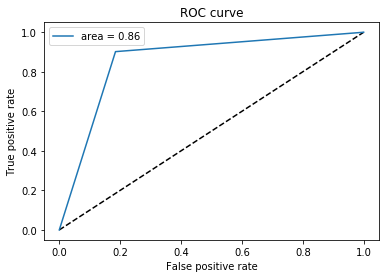

In [16]:
#to make prediction
y_pred_1 = model1.predict(X_test_v2)

print('Accuracy of Multinomial Naive Bayes Classifier on training set: {:.2f}'
     .format(model1.score(X_train_v2, y_train_v2)))
print('Accuracy of Multinomial Naive Bayes Classifier on test set: {:.2f}'
     .format(model1.score(X_test_v2, y_test_v2)))
print('\nConfusion matrix :\n',confusion_matrix(y_test_v2, y_pred_1))
print('\n\nClassification report :\n\n', classification_report(y_test_v2, y_pred_1))


fpr1, tpr1, thresholds = roc_curve(y_test_v2, y_pred_1, pos_label=1)
auc_result1 = auc(fpr1, tpr1)
print('ROC Curve')
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, label='area = {0:0.2f}'.format(auc_result1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [17]:
#to show the top feature names 
vectorizer1 = model1.named_steps['vect']
clf1 = model1.named_steps['nb']
feature_names = vectorizer1.get_feature_names()
feature_names = np.asarray(feature_names)
target_names = ['MultinomialNB']
print("top 10 keywords")
for i, label in enumerate(target_names):
    top = np.argsort(clf1.coef_[i])[-10:]
    print("%s: %s" % (label, " ".join(feature_names[top])))

top 10 keywords
MultinomialNB: drive test knowledgeable sales friendly helpful staff friendly help friendly helpful help


### Model: Logistic Regression
Logistic regression is a statistical method for analyzing a dataset in which there are one or more independent variables that determine an outcome. The outcome is measured with a dichotomous variable (in which there are only two possible outcomes).

In [18]:
from sklearn.linear_model import LogisticRegression

pipeline2 = Pipeline([('vect', CountVectorizer(ngram_range=(1,2), stop_words="english")),
                     ('tfidf', TfidfTransformer()),
                     ('log', LogisticRegression())])

scores2 = cross_val_score(pipeline2, X_train_v2, y_train_v2, cv=5)
#Using K -fold cross-validation to partition training dataset so that the algorithms of our model will run several times. 
#Each time will choose a part as training data and another part as testing data to get the cross validation scores each time. 
#This method will overcome overfitting as we do our validation before any tuning on our training data.

# To get baseline on the mean scores from cross-validation (cv=5)
mean2 = scores2.mean()
std2 = scores2.std()
print('baseline_mean_score:',mean2)
print('baseline_std_score:',std2)

# Tuning parameters
grid2 = {'log__penalty': ['l1', 'l2']}

grid_search2 = GridSearchCV(pipeline2, param_grid=grid2, cv=5)

grid_search2.fit(X_train_v2, y_train_v2)
print("-----------")
print('grid_search_best_score', grid_search2.best_score_)
print('grid_search_best_parameters',grid_search2.best_params_)

baseline_mean_score: 0.9356129780244874
baseline_std_score: 0.008405864783820768
-----------
grid_search_best_score 0.9479332273449921
grid_search_best_parameters {'log__penalty': 'l1'}


In [19]:
#to apply the best model
pipeline2_best = Pipeline([('vect', CountVectorizer(ngram_range=(1,2), stop_words="english")),
                           ('tfidf', TfidfTransformer()),
                           ('log', LogisticRegression(penalty='l1'))])
model2_best = pipeline2_best.fit(X_train_v2, y_train_v2)
labels2_best = model2_best.predict(X_test_v2)

Accuracy of Logistics Regression on training set: 0.94
Accuracy of Logistics Regression on test set: 0.96

Confusion matrix :
 [[11590   420]
 [  115  1496]]


Classification report :

              precision    recall  f1-score   support

          0       0.99      0.97      0.98     12010
          1       0.78      0.93      0.85      1611

avg / total       0.97      0.96      0.96     13621

ROC Curve


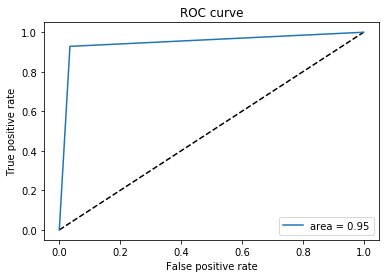

In [20]:
#to make prediction
y_pred_2_best = model2_best.predict(X_test_v2)

print('Accuracy of Logistics Regression on training set: {:.2f}'
     .format(model2_best.score(X_train_v2, y_train_v2)))
print('Accuracy of Logistics Regression on test set: {:.2f}'
     .format(model2_best.score(X_test_v2, y_test_v2)))
print('\nConfusion matrix :\n',confusion_matrix(y_test_v2, y_pred_2_best))
print('\n\nClassification report :\n\n', classification_report(y_test_v2, y_pred_2_best))


fpr2, tpr2, thresholds = roc_curve(y_test_v2, y_pred_2_best, pos_label=1)
auc_result2 = auc(fpr2, tpr2)
print('ROC Curve')
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr2, tpr2, label='area = {0:0.2f}'.format(auc_result2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [21]:
#to show the top feature names 
vectorizer2 = model2_best.named_steps['vect']
clf2 = model2_best.named_steps['log']
feature_names2 = vectorizer2.get_feature_names()
feature_names2 = np.asarray(feature_names2)
target_names = ['LogisticRegression']
print("top 10 keywords")
for i, label in enumerate(target_names):
    top2 = np.argsort(clf2.coef_[i])[-10:]
    print("%s: %s" % (label, " ".join(feature_names2[top2])))

top 10 keywords
LogisticRegression: accomod respectful accommod assist accomodating helped helpfull help accommodating helpful


### Stochastic Gradient Descent 
Stochastic Gradient Descent Classifier can optimize the same cost function as Linear Support Vector Machine by adjusting the penalty and loss parameters. In addition it requires less memory, allows incremental (online) learning, and implements various loss functions and regularization regimes

In [22]:
from sklearn.linear_model import SGDClassifier

pipeline3 = Pipeline([('vect', CountVectorizer(ngram_range=(1,2), stop_words="english")),
                     ('tfidf', TfidfTransformer()),
                     ('sgd', SGDClassifier())])

scores3 = cross_val_score(pipeline3, X_train_v2, y_train_v2, cv=5)

# To get baseline on the mean scores from cross-validation (cv=5)
mean3 = scores3.mean()
std3 = scores3.std()
print('baseline_mean_score:',mean3)
print('baseline_std_score:',std3)

# Tuning parameters
grid3 = {'sgd__penalty': ['l1','l2'],
         'sgd__loss': ['modified_huber','hinge','log'],
         'sgd__class_weight': ['balanced',None]}


grid_search3 = GridSearchCV(pipeline3, param_grid=grid3, cv=5)

grid_search3.fit(X_train_v2, y_train_v2)
print("-----------")
print('grid_search_best_score', grid_search3.best_score_)
print('grid_search_best_parameters',grid_search3.best_params_)

C:\Users\SiowHui.Chong\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\SiowHui.Chong\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\SiowHui

baseline_mean_score: 0.948065592776714
baseline_std_score: 0.008930995849573945


C:\Users\SiowHui.Chong\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\SiowHui.Chong\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\SiowHui

C:\Users\SiowHui.Chong\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\SiowHui.Chong\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\SiowHui

C:\Users\SiowHui.Chong\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\SiowHui.Chong\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\SiowHui

C:\Users\SiowHui.Chong\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\SiowHui.Chong\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\SiowHui

-----------
grid_search_best_score 0.9507154213036566
grid_search_best_parameters {'sgd__class_weight': 'balanced', 'sgd__loss': 'hinge', 'sgd__penalty': 'l1'}


C:\Users\SiowHui.Chong\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [23]:
#to apply the best model
pipeline3_best = Pipeline([('vect', CountVectorizer(ngram_range=(1,2), stop_words="english")),
                           ('tfidf', TfidfTransformer()),
                           ('sgd', SGDClassifier(penalty='l1',loss='hinge',class_weight='balanced'))])
model3_best = pipeline3_best.fit(X_train_v2, y_train_v2)
labels3_best = model3_best.predict(X_test_v2)

C:\Users\SiowHui.Chong\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Accuracy of SGD on training set: 0.96
Accuracy of SGD on test set: 0.96

Confusion matrix :
 [[11569   441]
 [   90  1521]]


Classification report :

              precision    recall  f1-score   support

          0       0.99      0.96      0.98     12010
          1       0.78      0.94      0.85      1611

avg / total       0.97      0.96      0.96     13621

ROC Curve


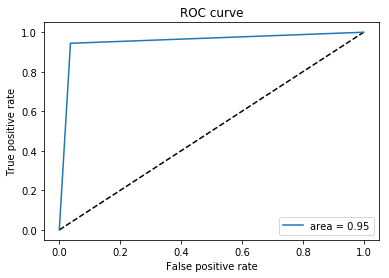

In [24]:
#to make prediction
y_pred_3_best = model3_best.predict(X_test_v2)

print('Accuracy of SGD on training set: {:.2f}'
     .format(model3_best.score(X_train_v2, y_train_v2)))
print('Accuracy of SGD on test set: {:.2f}'
     .format(model3_best.score(X_test_v2, y_test_v2)))
print('\nConfusion matrix :\n',confusion_matrix(y_test_v2, y_pred_3_best))
print('\n\nClassification report :\n\n', classification_report(y_test_v2, y_pred_3_best))


fpr3, tpr3, thresholds = roc_curve(y_test_v2, y_pred_3_best, pos_label=1)
auc_result3 = auc(fpr3, tpr3)
print('ROC Curve')
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr3, tpr3, label='area = {0:0.2f}'.format(auc_result3))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [25]:
#to show the top feature names 
vectorizer3 = model3_best.named_steps['vect']
clf3 = model3_best.named_steps['sgd']
feature_names3 = vectorizer3.get_feature_names()
feature_names3 = np.asarray(feature_names3)
target_names = ['SGDClassifier']
print("top 10 keywords")
for i, label in enumerate(target_names):
    top3 = np.argsort(clf3.coef_[i])[-10:]
    print("%s: %s" % (label, " ".join(feature_names3[top3])))

top 10 keywords
SGDClassifier: willing help respectful accommod helped assist helpfull accomodating help accommodating helpful


### Random Forest Classifier
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. 

In [26]:
from sklearn.ensemble import RandomForestClassifier

pipeline4 = Pipeline([('vect', CountVectorizer(ngram_range=(1,2), stop_words="english")),
                     ('tfidf', TfidfTransformer()),
                     ('rf', RandomForestClassifier())])

scores4 = cross_val_score(pipeline4, X_train_v2, y_train_v2, cv=5)

# To get baseline on the mean scores from cross-validation (cv=5)
mean4 = scores4.mean()
std4 = scores4.std()
print('baseline_mean_score:',mean4)
print('baseline_std_score:',std4)

# Tuning parameters
grid4 = {'rf__n_estimators': [10,20,50]}


grid_search4 = GridSearchCV(pipeline4, param_grid=grid4, cv=5)

grid_search4.fit(X_train_v2, y_train_v2)
print("-----------")
print('grid_search_best_score', grid_search4.best_score_)
print('grid_search_best_parameters',grid_search4.best_params_)

baseline_mean_score: 0.919183867057811
baseline_std_score: 0.012318667440356807
-----------
grid_search_best_score 0.9362745098039216
grid_search_best_parameters {'rf__n_estimators': 50}


In [27]:
#to apply the best model
pipeline4_best = Pipeline([('vect', CountVectorizer(ngram_range=(1,2), stop_words="english")),
                           ('tfidf', TfidfTransformer()),
                           ('rf', RandomForestClassifier(n_estimators=50))])
model4_best = pipeline4_best.fit(X_train_v2, y_train_v2)
labels4_best = model4_best.predict(X_test_v2)

Accuracy of Random Forest on training set: 1.00
Accuracy of Random Forest on test set: 0.97

Confusion matrix :
 [[11731   279]
 [  156  1455]]


Classification report :

              precision    recall  f1-score   support

          0       0.99      0.98      0.98     12010
          1       0.84      0.90      0.87      1611

avg / total       0.97      0.97      0.97     13621

ROC Curve


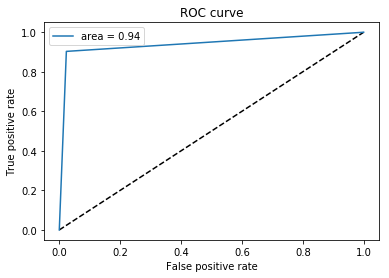

In [28]:
#to make prediction
y_pred_4_best = model4_best.predict(X_test_v2)

print('Accuracy of Random Forest on training set: {:.2f}'
     .format(model4_best.score(X_train_v2, y_train_v2)))
print('Accuracy of Random Forest on test set: {:.2f}'
     .format(model4_best.score(X_test_v2, y_test_v2)))
print('\nConfusion matrix :\n',confusion_matrix(y_test_v2, y_pred_4_best))
print('\n\nClassification report :\n\n', classification_report(y_test_v2, y_pred_4_best))


fpr4, tpr4, thresholds = roc_curve(y_test_v2, y_pred_4_best, pos_label=1)
auc_result4 = auc(fpr4, tpr4)
print('ROC Curve')
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr4, tpr4, label='area = {0:0.2f}'.format(auc_result4))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Conclusion

<img src="./Data/Model-v2.JPG", width=1000>

#### Choose: Logistic Regression: Simple and Fast with high accuracy and f1-score

### Prediction on unseen data

In [29]:
print(model1.predict(['Staff I dealt with was welcoming, easy to deal with as was willing to look at other options to try and assist.']))
print(model2_best.predict(['Staff I dealt with was welcoming, easy to deal with as was willing to look at other options to try and assist.']))
print(model3_best.predict(['Staff I dealt with was welcoming, easy to deal with as was willing to look at other options to try and assist.']))
print(model4_best.predict(['Staff I dealt with was welcoming, easy to deal with as was willing to look at other options to try and assist.']))

[1]
[1]
[1]
[1]


In [30]:
print(model1.predict(['They were very obliging showed through the vehicle and took me for test drive but my wife felt more comfortable driving smaller sedan']))
print(model2_best.predict(['They were very obliging showed through the vehicle and took me for test drive but my wife felt more comfortable driving smaller sedan']))
print(model3_best.predict(['They were very obliging showed through the vehicle and took me for test drive but my wife felt more comfortable driving smaller sedan']))
print(model4_best.predict(['They were very obliging showed through the vehicle and took me for test drive but my wife felt more comfortable driving smaller sedan']))

[0]
[0]
[0]
[0]


In [31]:
print(model1.predict(['They were really engaged. Went out of their way.  MakeX were arrogant for wnat of a better word.']))
print(model2_best.predict(['They were really engaged. Went out of their way.  MakeX were arrogant for wnat of a better word.']))
print(model3_best.predict(['They were really engaged. Went out of their way.  MakeX were arrogant for wnat of a better word.']))
print(model4_best.predict(['They were really engaged. Went out of their way.  MakeX were arrogant for wnat of a better word.']))

[0]
[0]
[1]
[1]
